# Exercise 2. MNIST classification with Tensorflow



### 1. 데이터 다운로드 (MNIST)

In [1]:
## Loading MNIST dataset from keras
import keras
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
## Printing dimensions
print(X_train.shape, y_train.shape)
## Visualizing the first digit
plt.imshow(X_train[0], cmap="Greys");

ModuleNotFoundError: No module named 'keras'

### 2. 데이터셋 Dimension 맞추기

In [48]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

print('Train dimension:');print(X_train.shape)
print('Test dimension:');print(X_test.shape)

## Changing labels to one-hot encoded vector
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
print('Train labels dimension:');print(y_train.shape)
print('Test labels dimension:');print(y_test.shape)

Train dimension:
(50000, 784)
Test dimension:
(10000, 784)
Train labels dimension:
(50000, 10)
Test labels dimension:
(10000, 10)


In [49]:
## Importing required libraries
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score
s = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 3. 네트워크 파라미터 셋팅

In [0]:
## Defining various initialization parameters for 784-512-256-10 MLP model
num_classes = y_train.shape[1]
num_features = X_train.shape[1]
num_output = y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001

### 4-1. Input placeholder 생성

In [0]:
# Placeholders for the input data
input_X = tf.placeholder('float32',shape =(None,num_features),name="input_X")
input_y = tf.placeholder('float32',shape = (None,num_classes),name='input_Y')


### 4-2. Weight & Bias Variable 생성

In [0]:
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.Variable(tf.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.random_normal([num_layers_0]))
weights_1 = tf.Variable(tf.random_normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.Variable(tf.random_normal([num_layers_1]))
weights_2 = tf.Variable(tf.random_normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.Variable(tf.random_normal([num_output]))

### 4-3. 네트워크 Forward Pass 정의

In [0]:
def forward_pass(input_x, input_y):

  hidden_output_0 = tf.nn.relu(tf.matmul(input_x,weights_0)+bias_0)
  hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0,weights_1)+bias_1)
  predicted_y = tf.sigmoid(tf.matmul(hidden_output_1,weights_2) + bias_2)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y))
  
  return predicted_y, loss

predicted_y, loss = forward_pass(input_X, input_y)

### 4-3. Optimizer, Metric 정의

In [0]:
## Variable learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
## Adam optimzer for finding the right weight
# optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2, bias_0,bias_1,bias_2])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,
                                                                         bias_0,bias_1,bias_2])

In [0]:
## Metrics definition
correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 5. Training

In [59]:
## Training parameters
batch_size = 128
epochs=14
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
s.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    for index in range(0,X_train.shape[0],batch_size):
        s.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
                          input_y: y_train[arr[index:index+batch_size]],
                         })
    training_accuracy.append(s.run(accuracy, feed_dict= {input_X:X_train, 
                                                         input_y: y_train}))
    training_loss.append(s.run(loss, {input_X: X_train, 
                                      input_y: y_train}))
    
    ## Evaluation of model
    testing_accuracy.append(accuracy_score(y_test.argmax(1), 
                            s.run(predicted_y, {input_X: X_test}).argmax(1)))
    print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))

Epoch:0, Train loss: 1.52 Train acc: 0.942, Test acc:0.940
Epoch:1, Train loss: 1.50 Train acc: 0.957, Test acc:0.954
Epoch:2, Train loss: 1.49 Train acc: 0.971, Test acc:0.964
Epoch:3, Train loss: 1.48 Train acc: 0.978, Test acc:0.970
Epoch:4, Train loss: 1.48 Train acc: 0.981, Test acc:0.972
Epoch:5, Train loss: 1.48 Train acc: 0.985, Test acc:0.974
Epoch:6, Train loss: 1.47 Train acc: 0.987, Test acc:0.976
Epoch:7, Train loss: 1.47 Train acc: 0.989, Test acc:0.977
Epoch:8, Train loss: 1.47 Train acc: 0.990, Test acc:0.977
Epoch:9, Train loss: 1.47 Train acc: 0.992, Test acc:0.979
Epoch:10, Train loss: 1.47 Train acc: 0.993, Test acc:0.977
Epoch:11, Train loss: 1.47 Train acc: 0.989, Test acc:0.973
Epoch:12, Train loss: 1.47 Train acc: 0.994, Test acc:0.979
Epoch:13, Train loss: 1.47 Train acc: 0.994, Test acc:0.978


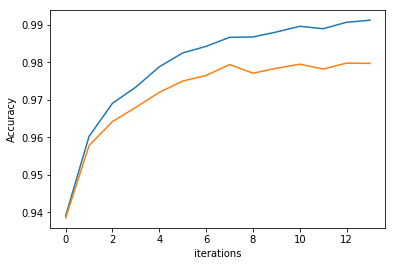

Train Accuracy: 0.99
Test Accuracy:0.98


In [0]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))

sample_size = 10

samples = s.run(forward_pass(input_X, input_y)[0], 
                feed_dict={input_X: X_test[:sample_size], input_y: y_test[:sample_size]})
prediction = samples.argmax(1)
fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

for i in range(sample_size):

    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
 
    ax[0][i].imshow(np.reshape(X_test[i], (28, 28)))
    
plt.show()
print(prediction)